In [311]:
%matplotlib widget

In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.animation as animation

from scipy.linalg import expm
from scipy.signal import savgol_filter
from scipy import stats

import os
import pickle

In [313]:
# import opensim_ipython as osim

# import sys
# # Are we running this script as a test? Users can ignore this line!
# running_as_test = True  #'unittest' in str().join(sys.argv)

# # Define global model where the arm lives.
# arm = osim.Model()
# if not running_as_test: arm.setUseVisualizer(True)

# # ---------------------------------------------------------------------------
# # Create two links, each with a mass of 1 kg, centre of mass at the body's
# # origin, and moments and products of inertia of zero.
# # ---------------------------------------------------------------------------

# humerus = osim.Body("humerus",
#                     1.0,
#                     osim.Vec3(0, 0, 0),
#                     osim.Inertia(0, 0, 0))
# radius = osim.Body("radius",
#                    1.0,
#                    osim.Vec3(0, 0, 0),
#                    osim.Inertia(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Connect the bodies with pin joints. Assume each body is 1m long.
# # ---------------------------------------------------------------------------

# shoulder = osim.PinJoint("shoulder",
#                          arm.getGround(), # PhysicalFrame
#                          osim.Vec3(0, 0, 0),
#                          osim.Vec3(0, 0, 0),
#                          humerus, # PhysicalFrame
#                          osim.Vec3(0, 1, 0),
#                          osim.Vec3(0, 0, 0))

# elbow = osim.PinJoint("elbow",
#                       humerus, # PhysicalFrame
#                       osim.Vec3(0, 0, 0),
#                       osim.Vec3(0, 0, 0),
#                       radius, # PhysicalFrame
#                       osim.Vec3(0, 1, 0),
#                       osim.Vec3(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Add a muscle that flexes the elbow (actuator for robotics people).
# # ---------------------------------------------------------------------------

# biceps = osim.Millard2012EquilibriumMuscle("biceps",  # Muscle name
#                                            200.0,  # Max isometric force
#                                            0.6,  # Optimal fibre length
#                                            0.55,  # Tendon slack length
#                                            0.0)  # Pennation angle
# biceps.addNewPathPoint("origin",
#                        humerus,
#                        osim.Vec3(0, 0.8, 0))

# biceps.addNewPathPoint("insertion",
#                        radius,
#                        osim.Vec3(0, 0.7, 0))

# # ---------------------------------------------------------------------------
# # Add a controller that specifies the excitation of the muscle.
# # ---------------------------------------------------------------------------

# brain = osim.PrescribedController()
# brain.addActuator(biceps)
# brain.prescribeControlForActuator("biceps",
#                                   osim.StepFunction(0.5, 3.0, 0.3, 1.0))

# # ---------------------------------------------------------------------------
# # Build model with components created above.
# # ---------------------------------------------------------------------------

# arm.addBody(humerus)
# arm.addBody(radius)
# arm.addJoint(shoulder) # Now required in OpenSim4.0
# arm.addJoint(elbow)
# arm.addForce(biceps)
# arm.addController(brain)

# # ---------------------------------------------------------------------------
# # Add a console reporter to print the muscle fibre force and elbow angle.
# # ---------------------------------------------------------------------------

# # We want to write our simulation results to the console.
# reporter = osim.ConsoleReporter()
# reporter.set_report_time_interval(1.0)
# reporter.addToReport(biceps.getOutput("fiber_force"))
# elbow_coord = elbow.getCoordinate().getOutput("value")
# reporter.addToReport(elbow_coord, "elbow_angle")
# arm.addComponent(reporter)

# # ---------------------------------------------------------------------------
# # Add display geometry. 
# # ---------------------------------------------------------------------------

# bodyGeometry = osim.Ellipsoid(0.1, 0.5, 0.1)
# bodyGeometry.setColor(osim.Gray)
# humerusCenter = osim.PhysicalOffsetFrame()
# humerusCenter.setName("humerusCenter")
# humerusCenter.setParentFrame(humerus)
# humerusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# humerus.addComponent(humerusCenter)
# humerusCenter.attachGeometry(bodyGeometry.clone())

# radiusCenter = osim.PhysicalOffsetFrame()
# radiusCenter.setName("radiusCenter")
# radiusCenter.setParentFrame(radius)
# radiusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# radius.addComponent(radiusCenter)
# radiusCenter.attachGeometry(bodyGeometry.clone())

# # ---------------------------------------------------------------------------
# # Configure the model.
# # ---------------------------------------------------------------------------

# state = arm.initSystem()
# # Fix the shoulder at its default angle and begin with the elbow flexed.
# shoulder.getCoordinate().setLocked(state, True)
# elbow.getCoordinate().setValue(state, 0.5 * osim.SimTK_PI)
# arm.equilibrateMuscles(state)

# # ---------------------------------------------------------------------------
# # Simulate.
# # ---------------------------------------------------------------------------

# manager = osim.Manager(arm)
# state.setTime(0)
# manager.initialize(state)
# state = manager.integrate(10.0)

# # ---------------------------------------------------------------------------
# # Print/save model file
# # ---------------------------------------------------------------------------

# arm.printToXML("SimpleArm.osim")

In [574]:
REPEATED_MOVEMENTS = False

filepath = "~/user-in-the-box/output/log_one_policy_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log.pickle"
filepath = "~/user-in-the-box/output/state_log.pickle"
filepath = "~/user-in-the-box/output/with-camera-dwelling-selection-100episodes.pickle"
filepath = "~/user-in-the-box/output/TwoLevelSL-100Hz-state-log.pickle"
filepath = "~/user-in-the-box/output/tracking-OnePolicy-composite-10runs-100Hz.pickle"

#filename = "pointing-OnePolicy-basic-stochastic"
#filename = "pointing-OnePolicy-neural_effort-stochastic"
#filename = "pointing-OnePolicy-composite-stochastic"
#filename = "tracking-OnePolicy-basic-stochastic"
#filename = "tracking-OnePolicy-neural_effort-stochastic"
#filename = "tracking-OnePolicy-composite-stochastic"
#filepath = f"~/user-in-the-box/output/{filename}.pickle"

filename = "NegativeExpDistance-neural"
filename = "NegativeExpDistance-composite"
filename = "NegativeExpDistance-muscle_state"
filepath = f"~/user-in-the-box/output/NegativeExpDistance/{filename}/state_log.pickle"

#filename = "state_log(3)"
#filepath = f"~/user-in-the-box/output/{filename}.pickle"

with open(os.path.expanduser(filepath), "rb") as f:
    data = pickle.load(f)
    
    
# ### REPEATED MOVEMENTS
# REPEATED_MOVEMENTS = True

# RADIUS_ID_NUMS = 5  #number of different radii per movement

# filename = "NegativeExpDistance-neural/repeated-movements"
# filepath = f"~/user-in-the-box/output/{filename}/"  #warning: here, "filepath" is directory!

# rep_movs_data = {}
# for subdir in [i for i in os.listdir((os.path.expanduser(filepath))) if os.path.isdir(os.path.join(os.path.expanduser(filepath), i))]:
#     subdir_abs = os.path.join(os.path.expanduser(filepath), subdir)
#     for subsubdir in [i for i in os.listdir(subdir_abs) if os.path.isdir(os.path.join(subdir_abs, i))]:
#         subsubdir_abs = os.path.join(os.path.expanduser(filepath), subdir, subsubdir)
#         rep_movs_filepath = os.path.join(subsubdir_abs, "state_log.pickle")
#         with open(os.path.expanduser(rep_movs_filepath), "rb") as f:
#             helper = pickle.load(f)
#             for k, v in helper.items():
#                 rep_movs_data[f"{subdir}__{subsubdir}__{k}"] = v
# data = rep_movs_data
#######################

if not os.path.exists(f"plots/{filename}"):  #create plot (sub-)directories
    os.makedirs(f"plots/{filename}")

In [575]:
def project_trajectory(trajectory, init_val=None, final_val=None, use_rel_vals=True, output_deviation=False):
    #INFO: use_rel_vals should be True when projecting position, but not when projecting velocity, acceleration, etc.!
    #INFO: if output_deviation is True, deviation from direct path between initial and target position
    if init_val is None:
        init_val = trajectory[0]
    if final_val is None:
        final_val = trajectory[-1]
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    proj_vector = final_val - init_val
    proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)**2  #normalize vector to project on
    proj_vector_normalized = proj_vector_normalized.flatten()
    
    projected_trajectory = np.array([np.dot(state_vec - init_val*use_rel_vals, proj_vector_normalized) for state_vec in trajectory])
    
    if output_deviation:
        # compute deviation from direct path
        projected_trajectory_deviation = np.array([np.linalg.norm((state_vec - init_val*use_rel_vals) - state_vec_projected*proj_vector) for state_vec, state_vec_projected in zip(trajectory, projected_trajectory)])
        return projected_trajectory_deviation
    
    return projected_trajectory

def project_trajectory_cov(trajectory, init_val, final_val,):
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    proj_vector = final_val - init_val
    proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)**2  #normalize vector to project on
    proj_vector_normalized = proj_vector_normalized.flatten()
    
    projected_trajectory_cov = np.array([np.dot(proj_vector_normalized, np.dot(state_cov, proj_vector_normalized)) for state_cov in trajectory])
    return projected_trajectory_cov

In [576]:
# Compute Minjerk trajectory as reference trajectory
def minimumjerk_deterministic(N, T, initialuservalues, dim, P, dt, x0, final_vel=None, final_acc=None, passage_times=None):
    if x0 is None:
        x0 = np.hstack((np.mean(np.squeeze(initialuservalues), axis=0), T[0]))

    if passage_times is None:
        passage_times = np.linspace(0, N, P).astype(
            int)  # WARNING: here: equally distributed target passage times!
    # else:
    #     passage_times = np.insert(passage_times, 0, 0)  #assume that argument "passage_times" had P - 1 values, as first "target switch" (i.e., from initial position to first real target) is fixed

    assert len(passage_times) == P

    n = dim * (3 + P)  # dimension of state vector (incorporating position, velocity, acceleration and "via-points" T)

    assert P == 2
    N_minjerk = np.ceil(passage_times[1]).astype(int)
    
    if final_vel is None:  #only used in VARIANT 2
        final_vel = np.zeros((dim,))
    if final_acc is None:  #only used in VARIANT 2
        final_acc = np.zeros((dim,))
    assert final_vel.shape == (dim,)
    assert final_acc.shape == (dim,)
        
#     ### VARIANT 1:  (this variant terminates with zero velocity and acceleration, independent of "final_vel" and "final_acc"!)
#     ## (Online) Control Algorithm
    
#     A = [None] * (N_minjerk)
#     B = [None] * (N_minjerk)
    
#     x = np.zeros((N + 1, n))
#     u = np.zeros((N, dim))

#     x[0] = x0
#     for i in range(0, N_minjerk):
#         u[i] = T[0][1*dim:]

#         ### COMPUTE time-dependent system matrices (with time relexation due to usage of passage_times[1] instead of int(passage_times[1]); for stochastic wrapper, see minjerk_get_all_timedependent_system_matrices()):
#         movement_time = (passage_times[1] - i) * dt
#         A_continuous = np.vstack(
#             (np.hstack((np.zeros(shape=(dim, dim)), np.eye(dim), np.zeros(shape=(dim, (P + 1) * dim)))),
#              np.hstack((np.zeros(shape=(dim, 2 * dim)), np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.hstack(((-60 / (movement_time ** 3)) * np.eye(dim), (-36 / (movement_time ** 2)) * np.eye(dim),
#                         (-9 / movement_time) * np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.zeros(shape=(P * dim, (P + 3) * dim))))
#         B_continuous = np.vstack((np.zeros(shape=(2 * dim, dim)),
#                                   (60 / (movement_time ** 3)) * np.eye(dim), np.zeros(shape=(P * dim, dim))))
#         # using explicit solution formula:
#         A[i] = expm(A_continuous * dt)
#         B[i] = np.linalg.pinv(A_continuous).dot(A[i] - np.eye((3 + P) * dim)).dot(B_continuous)
#         # B[i] = np.vstack((np.linalg.inv(A_continuous[:3*dim, :3*dim]).dot(A[i][:3*dim, :3*dim] - np.eye(3 * dim)).dot(B_continuous[:3*dim]),
#         #                     np.zeros(shape=(P * dim, dim))))
#         ############################################

#         x[i + 1] = A[i].dot(x[i]) + B[i].dot(u[i])

#     for i in range(N_minjerk, N):  # extend trajectory with constant last value
#         u[i] = T[0][1*dim:]
#         x[i + 1] = x[i] * np.repeat(np.array([1, 0, 0, 1, 1]), dim)

    ### VARIANT 2:
    # Explicit Solution Formula (current implementation only yields position time series!)
    t_f = passage_times[1] * dt
    #compute MinJerk trajectory per dimension
    
    #SHORT CODE:
    coeff_vec = np.array([[x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
                       -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
                       15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
                       -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]] for i in range(dim)] + 
                    [[x0[1*dim + i], t_f * x0[2*dim + i],
                       (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                       (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                       (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0] for i in range(dim)] +
                    [[x0[2*dim + i],
                   (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                   (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                   (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0, 0] for i in range(dim)])
    x = np.squeeze([coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)])
    #LONG CODE:
    # x = []
    # for i in range(dim):  #position
    #     coeff_vec = np.array([x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
    #                        -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
    #                        15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
    #                        -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #velocity
    #     coeff_vec = np.array([x0[1*dim + i], t_f * x0[2*dim + i],
    #                        (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(5)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #acceleration
    #     coeff_vec = np.array([x0[2*dim + i],
    #                        (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(4)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # x = np.array(x).T
    
    if N > N_minjerk:
        x = np.concatenate((x, [x[-1]] * (N - N_minjerk)))
    u = None  #[T[0][1*dim:]] * (N_minjerk + 1)

    return x, u



In [577]:
# x_minjerk, u_minjerk = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)
# x_minjerk, u_minjerk

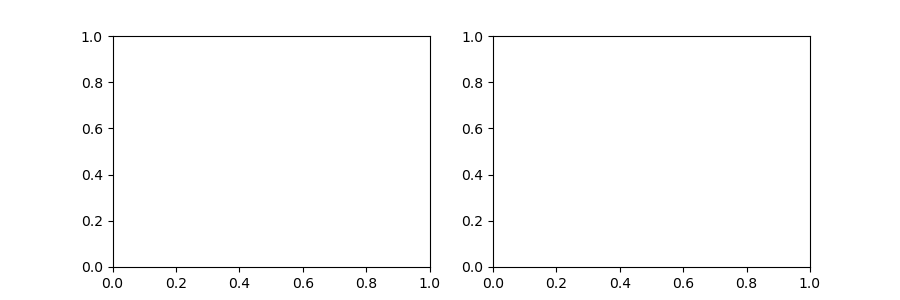

In [578]:
if "endeffector_fig" in locals():
    plt.close(endeffector_fig)
# endeffector_fig = plt.figure()
# endeffector_ax = endeffector_fig.gca()

SHOW_ANIMATION = False

plt.ion()
if not SHOW_ANIMATION:
    endeffector_fig, endeffector_ax = plt.subplots(1, 2, figsize=[9, 3])
else:
    endeffector_fig = plt.figure(figsize=[9, 9])
    endeffector_ax = []
    for i in range(1):
        endeffector_ax.append(endeffector_fig.add_subplot(1, 1, i + 1, projection='3d'))

In [604]:
for axis in endeffector_ax:
    axis.clear()
endeffector_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.26, hspace=0.2)

####
MOVEMENT_ID = "0".zfill(len(list(data.keys())[0].split("movement_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True
RADIUS_ID = "ALL"  #"1".zfill(len(list(data.keys())[0].split("radius_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True

EPISODE_ID = "2".zfill(len(list(data.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
#EPISODE_ID = "VARIABLE"
NORMALIZE_TIME = False
MINJERK_USER_CONSTRAINTS = True

CONF_LEVEL = "min/max"  # might be between 0 and 1, or "min/max"; only used if EPISODE_ID == "VARIABLE"

N_MOVS = 3 #number of movements to visualize
SHOW_DIFFERENT_TARGET_SIZES = True
USE_MEAN_TRAJECTORIES = False

PLOT_TIME_SERIES = True  #if True plot Position and Velocity Time Series, else plot Phasespace and Hooke plots
PLOT_DEVIATION = False
SHOW_MINJERK = False

#REPEATED_MOVEMENTS (defined above)
#RADIUS_ID_NUMS (defined above)
#EPISODE_ID_NUMS (defined above)
EPISODE_ID_NUMS = 5

#SHOW_ANIMATION (defined above)
####    

if EPISODE_ID == "VARIABLE":
    assert REPEATED_MOVEMENTS, "ERROR: Check code dependencies..."
    #assert not PLOT_DEVIATION, "Deviation plots have not been tested yet with variable episodes."
    assert PLOT_TIME_SERIES, "Plotting distributions (e.g., as CI or min/max-ranges) of Phasepace/Hooke profiles is not implemented yet."

if PLOT_DEVIATION:
    assert PLOT_TIME_SERIES, "Deviation should be plotted as Time Series, not as Phasespace/Hooke plots."

if REPEATED_MOVEMENTS:
    if EPISODE_ID == "VARIABLE":
        EPISODE_ID_LIST = [f"{EPISODE_ID_CURRENT}".zfill(len(list(data.keys())[0].split("episode_")[-1])) for EPISODE_ID_CURRENT in range(EPISODE_ID_NUMS)]
    else:
        EPISODE_ID_LIST = [EPISODE_ID]
    
if EPISODE_ID == "VARIABLE":  #concatenate all movement trajectories
    for RADIUS_ID_CURRENT in range(RADIUS_ID_NUMS):
        data[f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"] = {}
        for EPISODE_ID_CURRENT in EPISODE_ID_LIST:
            data_key = f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID_CURRENT}"
            for k, v in data[data_key].items():
                data[f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"][k] = v if k not in data[f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"] else data[f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"][k] + v
    data_key = f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"  #WARNING: only used if EPISODE_ID == "VARIABLE"!
else:
    data_key = f"episode_{EPISODE_ID}"
    
if RADIUS_ID == "ALL" and REPEATED_MOVEMENTS:
    position_series = []
    velocity_series = []
    acceleration_series = []
    target_position_series = []
    target_radius_series = []
    time_series = []
    time_per_step = []
    indices = []
    
    for RADIUS_ID_CURRENT in range(RADIUS_ID_NUMS):
        data_key = f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"
        position_series.append(np.squeeze(data[data_key]["fingertip_xpos"]))
        velocity_series.append(np.squeeze(data[data_key]["fingertip_xvelp"]))
        target_position_series.append(np.squeeze(data[data_key]["target_position"]))
        target_radius_series.append(np.squeeze(data[data_key]["target_radius"]))
        time_series.append(np.squeeze(data[data_key]["timestep"]))

        time_per_step.append(0.01 if REPEATED_MOVEMENTS else np.diff(time_series[-1]).mean())  #0.01
        #current_indices = np.append(np.insert(np.where(data[data_key]["target_hit"])[0], 0, 0), len(data[data_key]["target_hit"]))
        current_indices = np.insert(np.where(data[data_key]["target_spawned"])[0], 0, 0)
        if len(current_indices) <= 2:  #recompute indices based on switches in target position
            current_indices = np.where(np.diff(np.squeeze(target_position_series[-1]), axis=0).sum(axis=1))[0] + 1
        assert len(current_indices) > 2
        indices.append(current_indices)

        # recover end-effector position time series [only for corrupted pickle file]
        if filepath in ["log.pickle", "state_log.pickle"] or filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
            current_position_series = (np.cumsum(velocity_series[-1], axis=0) * time_per_step[-1])
            current_position_series = pd.DataFrame(current_position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step[-1])).values
            current_position_series += target_position_series[-1][indices[1] - 1] - current_position_series[indices[1] - 1] #ensure that target is reached at target hit/switch time
            position_series[-1] = current_position_series
            
        #velocity_series.append(pd.DataFrame(position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = time_per_step[-1])).values)
        acceleration_series.append(pd.DataFrame(position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = time_per_step[-1])).values)
    
    assert len(position_series) == len(acceleration_series)
    assert len(position_series) == len(velocity_series)
    assert len(position_series) == len(target_position_series)
    assert len(position_series) == len(target_radius_series)
        
#     # Compute mean and covariance for each trial of position_series/velocity_series/acceleration_series
#     position_series_mean = []
#     position_series_cov = []
#     position_series_min = []
#     position_series_max = []
#     velocity_series_mean = []
#     velocity_series_cov = []
#     velocity_series_min = []
#     velocity_series_max = []
#     acceleration_series_mean = []
#     acceleration_series_cov = []
#     acceleration_series_min = []
#     acceleration_series_max = []
#     target_position_series_mean = []
#     target_position_series_cov = []  #should be zero!
#     target_radius_series_mean = []
#     target_radius_series_cov = []  #should be zero!
#     time_series_normaldist = []
#     indices_normaldist = [0]

#     assert len((n_trials := np.unique(list(map(lambda x: len(x), indices))))) == 1, "ERROR: Episodes have different numbers of identified trials! Cannot reliably identify which trials to aggregate."

#     for current_meta_idx in range(n_trials[0] - 1):
#         current_position_subseries = [k[current_idx:next_idx] for episode_id, k in enumerate(position_series) if (current_idx := indices[episode_id][current_meta_idx]) is not None and (next_idx := indices[episode_id][current_meta_idx + 1]) is not None]
#         current_velocity_subseries = [k[current_idx:next_idx] for episode_id, k in enumerate(velocity_series) if (current_idx := indices[episode_id][current_meta_idx]) is not None and (next_idx := indices[episode_id][current_meta_idx + 1]) is not None]
#         current_acceleration_subseries = [k[current_idx:next_idx] for episode_id, k in enumerate(acceleration_series) if (current_idx := indices[episode_id][current_meta_idx]) is not None and (next_idx := indices[episode_id][current_meta_idx + 1]) is not None]
#         current_target_position_subseries = [k[current_idx:next_idx] for episode_id, k in enumerate(target_position_series) if (current_idx := indices[episode_id][current_meta_idx]) is not None and (next_idx := indices[episode_id][current_meta_idx + 1]) is not None]
#         current_target_radius_subseries = [k[current_idx:next_idx] for episode_id, k in enumerate(target_radius_series) if (current_idx := indices[episode_id][current_meta_idx]) is not None and (next_idx := indices[episode_id][current_meta_idx + 1]) is not None]
#         data_lengths = sorted([len(i) for i in current_position_subseries], reverse=True)        
        
#         position_series_mean += [np.mean([k[j] for k in current_position_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         position_series_cov += [((np.cov([k[j] for k in current_position_subseries if j < k.shape[0]], rowvar=False))) for j in range(data_lengths[1])] + [np.zeros((3,3)) for _ in range(data_lengths[1], data_lengths[0])]
#         position_series_min += [np.min([k[j] for k in current_position_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         position_series_max += [np.max([k[j] for k in current_position_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         velocity_series_mean += [np.mean([k[j] for k in current_velocity_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         velocity_series_cov += [((np.cov([k[j] for k in current_velocity_subseries if j < k.shape[0]], rowvar=False))) for j in range(data_lengths[1])] + [np.zeros((3,3)) for _ in range(data_lengths[1], data_lengths[0])]
#         velocity_series_min += [np.min([k[j] for k in current_velocity_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         velocity_series_max += [np.max([k[j] for k in current_velocity_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         acceleration_series_mean += [np.mean([k[j] for k in current_acceleration_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         acceleration_series_cov += [((np.cov([k[j] for k in current_acceleration_subseries if j < k.shape[0]], rowvar=False))) for j in range(data_lengths[1])] + [np.zeros((3,3)) for _ in range(data_lengths[1], data_lengths[0])]
#         acceleration_series_min += [np.min([k[j] for k in current_acceleration_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         acceleration_series_max += [np.max([k[j] for k in current_acceleration_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         target_position_series_mean += [np.mean([k[j] for k in current_target_position_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         target_position_series_cov += [((np.cov([k[j] for k in current_target_position_subseries if j < k.shape[0]], rowvar=False))) for j in range(data_lengths[1])] + [np.zeros((3,3)) for _ in range(data_lengths[1], data_lengths[0])]
#         target_radius_series_mean += [np.mean([k[j] for k in current_target_radius_subseries if j < k.shape[0]], axis=0) for j in range(data_lengths[0])]
#         target_radius_series_cov += [((np.cov([k[j] for k in current_target_radius_subseries if j < k.shape[0]], rowvar=False))) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])]
        
#         assert len(position_series_mean) == len(position_series_cov)  #ensure that indices_normaldist applies to both position_series_mean and position_series_cov
#         indices_normaldist += [len(position_series_mean)]
        
        
#         # Reset time series after each trial, as we use comptued "mean" trials which do not have an actual time correspondence in original data
#         if np.cov(time_per_step) != 0:
#             print(f"WARNING: Check whether time_per_step was computed correctly, to ensure that time series are correctly aligned.")
#         time_series_normaldist += list(np.arange(indices_normaldist[-1] - indices_normaldist[-2]) * np.mean(time_per_step))

#     position_series = np.squeeze(position_series_mean)
#     position_series_cov = np.squeeze(position_series_cov)
#     position_series_min = np.squeeze(position_series_min)
#     position_series_max = np.squeeze(position_series_max)
#     velocity_series = np.squeeze(velocity_series_mean)
#     velocity_series_cov = np.squeeze(velocity_series_cov)
#     velocity_series_min = np.squeeze(velocity_series_min)
#     velocity_series_max = np.squeeze(velocity_series_max)
#     acceleration_series = np.squeeze(acceleration_series_mean)
#     acceleration_series_cov = np.squeeze(acceleration_series_cov)
#     acceleration_series_min = np.squeeze(acceleration_series_min)
#     acceleration_series_max = np.squeeze(acceleration_series_max)
#     target_position_series = np.squeeze(target_position_series_mean)
#     target_position_series_cov = np.squeeze(target_position_series_cov)
#     target_radius_series = np.squeeze(target_radius_series_mean)
#     target_radius_series_cov = np.squeeze(target_radius_series_cov)
#     time_series = np.squeeze(time_series_normaldist)

#     assert np.isclose(np.max(target_position_series_cov), 0), "ERROR: Variance of target position is not zero! Something must have went wrong during assignment of corresponding trials..."
#     assert np.isclose(np.max(target_radius_series_cov), 0), "ERROR: Variance of target radius is not zero! Something must have went wrong during assignment of corresponding trials..."
        
    # reset data_key for storing to correct file:
    RADIUS_ID_CURRENT = "ALL"
    data_key = f"movement_{MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID}"

else:
    position_series = data[data_key]["fingertip_xpos"]
    velocity_series = data[data_key]["fingertip_xvelp"]
    target_position_series = data[data_key]["target_position"]
    target_radius_series = data[data_key]["target_radius"]
    time_series = data[data_key]["timestep"]

    time_per_step = np.diff(time_series).mean()  #0.01
    #indices = np.append(np.insert(np.where(data[data_key]["target_hit"])[0], 0, 0), len(data[data_key]["target_hit"]))
    indices = np.insert(np.where(data[data_key]["target_spawned"])[0], 0, 0)
    if len(indices) <= 2:  #recompute indices based on switches in target position
        indices = np.where(np.diff(np.squeeze(target_position_series), axis=0).sum(axis=1))[0] + 1
    assert len(indices) > 2

    # recover end-effector position time series [only for corrupted pickle file]
    if filepath in ["log.pickle", "state_log.pickle"] or filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
        position_series = (np.cumsum(velocity_series, axis=0) * time_per_step)
        position_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step)).values
        position_series += target_position_series[indices[1] - 1] - position_series[indices[1] - 1] #ensure that target is reached at target hit/switch time

    #velocity_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = time_per_step)).values
    acceleration_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = time_per_step)).values
    
## ANALYSIS OF POINTING TASKS -> Use trajectories projections onto direct path between initial and (fixed) target position
if not SHOW_ANIMATION:
    solid_line = Line2D([0], [0], color='black', linestyle='-', label='Simulation Data')
    dashed_line = Line2D([0], [0], color='black', linestyle='--', label='MinJerk Trajectory')
    confidence_interval_handle = Patch(facecolor='grey', alpha=.2, label='Range' if CONF_LEVEL == "min/max" else f'{100*CONF_LEVEL}%-CI')
    
    if SHOW_MINJERK:
        endeffector_ax[0].legend(handles=[solid_line, dashed_line])
    else:
        endeffector_ax[0].legend(handles=[solid_line])
    if PLOT_DEVIATION:
        endeffector_ax[0].set_title("Position Deviation from Direct Path")
        endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
        endeffector_ax[0].set_ylabel("Position Deviation (m)")

        endeffector_ax[1].set_title("Velocity Deviation from Direct Path")
        endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
        endeffector_ax[1].set_ylabel("Velocity Deviation (m/s)")
    else:
        if PLOT_TIME_SERIES:
            endeffector_ax[0].set_title("Projected Position Time Series")
            endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
            endeffector_ax[0].set_ylabel("Position [normalized]")

            endeffector_ax[1].set_title("Projected Velocity Time Series")
            endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
            endeffector_ax[1].set_ylabel("Velocity (1/s) [normalized]")
        else:
            endeffector_ax[0].set_title("Projected Phasespace Plot")
            endeffector_ax[0].set_xlabel("Position [normalized]")
            endeffector_ax[0].set_ylabel("Velocity [normalized]")

            endeffector_ax[1].set_title("Projected Hooke Plot")
            endeffector_ax[1].set_xlabel("Position [normalized]")
            endeffector_ax[1].set_ylabel("Acceleration [normalized]")

## ANALYSIS OF TRACKING TASKS -> Use 3D plots of trajectories
else:
    blue_line = Line2D([0], [0], color='tab:blue', linestyle='-', label='End-Effector')
    red_line = Line2D([0], [0], color='red', linestyle='-', label='Target')
    endeffector_ax[0].legend(handles=[blue_line, red_line])
    
    endeffector_ax[0].set_title("Position Trajectory")
    endeffector_ax[0].set_xlabel("x")
    endeffector_ax[0].set_ylabel("y")
    endeffector_ax[0].set_zlabel("z")
    ax_lims = np.vstack((np.min((np.squeeze(position_series).min(axis=0), np.squeeze(target_position_series).min(axis=0)), axis=0), np.max((np.squeeze(position_series).max(axis=0), np.squeeze(target_position_series).max(axis=0)), axis=0))).T
    # endeffector_ax[0].set_xlim(*ax_lims[0, :])
    # endeffector_ax[0].set_ylim(*ax_lims[1, :])
    # endeffector_ax[0].set_zlim(*ax_lims[2, :])
    ax_lims_centers, ax_lims_ranges = ax_lims.mean(axis=1), ax_lims@[-1, 1]
    endeffector_ax[0].set_xlim(ax_lims_centers[0] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[0] + 0.5*np.max(ax_lims_ranges))
    endeffector_ax[0].set_ylim(ax_lims_centers[1] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[1] + 0.5*np.max(ax_lims_ranges))
    endeffector_ax[0].set_zlim(ax_lims_centers[2] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[2] + 0.5*np.max(ax_lims_ranges))

if EPISODE_ID == "VARIABLE":
#     init_vals = [i[0] for i in target_position_series]
#     target_vals = [i[1] for i in target_position_series]
#     assert np.unique(init_vals).shape == (3,)
#     assert np.unique(target_vals).shape == (3,)
#     assert np.unique(init_vals) is not np.unique(target_vals)
    
#     selected_movements_indices = list(zip(np.concatenate(([-1], indices_normaldist)), indices_normaldist, indices_normaldist[1:]))[1::2]
#     assert len(selected_movements_indices) == RADIUS_ID_NUMS if RADIUS_ID == "ALL" else 1
    
    selected_movements_indices = [list(zip(np.concatenate(([-1], indices_radius)), indices_radius, indices_radius[1:]))[1::2] for indices_radius in indices]
    assert len(selected_movements_indices) == RADIUS_ID_NUMS if RADIUS_ID == "ALL" else 1
    
    # concatenate last_idx, current_idx, and next_idx for all trials:
    selected_movements_indices = [tuple([selected_movements_indices_radius_trial[j] for selected_movements_indices_radius_trial in selected_movements_indices_radius] for j in range(3)) for selected_movements_indices_radius in selected_movements_indices]
elif REPEATED_MOVEMENTS:
    selected_movements_indices = [list(zip(np.concatenate(([-1], indices_radius)), indices_radius, indices_radius[1:]))[1::2] for indices_radius in indices]
    assert len(selected_movements_indices) == RADIUS_ID_NUMS if RADIUS_ID == "ALL" else 1
    selected_movements_indices = [tuple([selected_movements_indices_radius_trial[j] for selected_movements_indices_radius_trial in selected_movements_indices_radius] for j in range(3)) for selected_movements_indices_radius in selected_movements_indices]
elif SHOW_DIFFERENT_TARGET_SIZES:
    selected_movements_indices = list(zip(np.concatenate(([-1], indices)), indices, indices[1:]))
    
    episode_target_radii = np.sort(np.unique(data[data_key]["target_radius"][:-1]))
    target_radii = episode_target_radii[np.round(np.linspace(0, len(episode_target_radii) - 1, min(N_MOVS, len(episode_target_radii)))).astype(int)]
    
    if USE_MEAN_TRAJECTORIES:
        
        raise NotImplementedError
    else:
        # for each of the N_MOVS values in target_radii, choose first movement with this target radius:
        selected_movements_indices_target_sizes = [(i, target_radius) for target_radius in target_radii for i in [j for j in selected_movements_indices if (data[data_key]["target_radius"][j[1]] == target_radius)][:1]]
        selected_movements_indices, target_sizes = list(map((lambda x: x[0]), selected_movements_indices_target_sizes)), list(map((lambda x: x[1]), selected_movements_indices_target_sizes))
else:
    if USE_MEAN_TRAJECTORIES:
        raise NotImplementedError  #deprecated
        selected_movements_indices = list(zip(np.concatenate(([-1], indices)), indices, indices[1:]))
        max_nsteps = max([nidx-cidx for _, cidx, nidx in selected_movements_indices])
        mean_trajectory = np.squeeze([np.mean([position_series[cidx + i] for _, cidx, nidx in selected_movements_indices if (cidx + i) < len(position_series)], axis=0) for i in range(max_nsteps)])
        
        #if same code as for plotting non-mean trajectories should be used:
        selected_movements_indices = [(-1, 0, max_nsteps)]
        position_series = mean_trajectory
        velocity_series = np.gradient(mean_trajectory, time_per_step, axis=0)
        target_position_series = mean_trajectory[-1].reshape(1,-1).repeat(max_nsteps, axis=0)
    else:
        selected_movements_indices = list(zip(np.concatenate(([-1], indices)), indices, indices[1:]))[:N_MOVS]

if isinstance(last_idx_hlp, list):
    position_series_COMPLETE = position_series.copy()
    velocity_series_COMPLETE = velocity_series.copy()
    acceleration_series_COMPLETE = acceleration_series.copy()
    target_position_series_COMPLETE = target_position_series.copy()
    target_radius_series_COMPLETE = target_radius_series.copy()
    time_series_COMPLETE = time_series.copy()
if not SHOW_ANIMATION:
    for episode_index_current, (last_idx_hlp, current_idx_hlp, next_idx_hlp) in enumerate(selected_movements_indices):
        if isinstance(last_idx_hlp, list):  #if EPISODE_ID == "VARIABLE"
            position_series = position_series_COMPLETE[episode_index_current]
            velocity_series = velocity_series_COMPLETE[episode_index_current]
            acceleration_series = acceleration_series_COMPLETE[episode_index_current]
            target_position_series = target_position_series_COMPLETE[episode_index_current]
            target_radius_series = target_radius_series_COMPLETE[episode_index_current]
            time_series = time_series_COMPLETE[episode_index_current]
            
            projected_trajectories_pos = []
            projected_trajectories_vel = []
            projected_trajectories_acc = []
            target_position_series_trial = []
            target_radius_series_trial = []
            time_series_trial = []
            
            init_val = np.unique(target_position_series[[i+1 for i in last_idx_hlp if i>=0]], axis=0).reshape(-1,)
            final_val = np.unique(target_position_series[[i+1 for i in current_idx_hlp if i>=0]], axis=0).reshape(-1,)
            assert init_val.shape == (3,), "ERROR: Cannot reliably determine (nominal) initial position."
            assert final_val.shape == (3,), "ERROR: Cannot reliably determine (nominal) target position."
            assert init_val is not final_val, "ERROR: Initial and target position do not differ!"
            for last_idx, current_idx, next_idx in zip(last_idx_hlp, current_idx_hlp, next_idx_hlp):
                time_series_shifted = np.array(time_series[current_idx: next_idx]) - time_series[current_idx]
                if NORMALIZE_TIME:
                    time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])
                # if REPEATED_MOVEMENTS and (RADIUS_ID == "ALL"):            
                #     init_val=position_series[current_idx]
                # else:
                #     init_val=target_position_series[last_idx] if last_idx >= 0 else position_series[0]
                # final_val=target_position_series[current_idx + 1] #or position_series[next_idx - 1]
                
                projected_trajectories_pos.append(project_trajectory(position_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=PLOT_DEVIATION))            
                projected_trajectories_vel.append(project_trajectory(velocity_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION))
                projected_trajectories_acc.append(project_trajectory(acceleration_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION))
                target_position_series_trial.append(target_position_series[current_idx: next_idx])
                target_radius_series_trial.append(target_radius_series[current_idx: next_idx])
                time_series_trial.append(time_series_shifted)
                
            data_lengths = sorted([len(i) for i in projected_trajectories_pos], reverse=True)  
            
            projected_trajectories_pos_mean = np.array([np.mean([k[j] for k in projected_trajectories_pos if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
            projected_trajectories_vel_mean = np.array([np.mean([k[j] for k in projected_trajectories_vel if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
            projected_trajectories_acc_mean = np.array([np.mean([k[j] for k in projected_trajectories_acc if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
            target_pos_mean = np.array([np.mean([k[j] for k in target_position_series_trial if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
            target_radius_mean = np.array([np.mean([k[j] for k in target_radius_series_trial if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
            time_series_mean = np.array([np.mean([k[j] for k in time_series_trial if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
            if EPISODE_ID == "VARIABLE":
                projected_trajectories_pos_cov = np.array([np.cov([k[j] for k in projected_trajectories_pos if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])])
                projected_trajectories_pos_min = np.array([np.min([k[j] for k in projected_trajectories_pos if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
                projected_trajectories_pos_max = np.array([np.max([k[j] for k in projected_trajectories_pos if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
                projected_trajectories_vel_cov = np.array([np.cov([k[j] for k in projected_trajectories_vel if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])])
                projected_trajectories_vel_min = np.array([np.min([k[j] for k in projected_trajectories_vel if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
                projected_trajectories_vel_max = np.array([np.max([k[j] for k in projected_trajectories_vel if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
                projected_trajectories_acc_cov = np.array([np.cov([k[j] for k in projected_trajectories_acc if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])])
                projected_trajectories_acc_min = np.array([np.min([k[j] for k in projected_trajectories_acc if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
                projected_trajectories_acc_max = np.array([np.max([k[j] for k in projected_trajectories_acc if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
                target_pos_cov = np.array([np.cov([k[j] for k in target_position_series_trial if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])])
                target_radius_cov = np.array([np.cov([k[j] for k in target_radius_series_trial if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])])
                time_series_cov = np.array([np.cov([k[j] for k in time_series_trial if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) for _ in range(data_lengths[1], data_lengths[0])])

                assert len(projected_trajectories_pos_mean) == len(projected_trajectories_pos_cov)  #ensure that indices_normaldist applies to both projected_trajectories_pos_mean and projected_trajectories_pos_cov
                #indices_normaldist += [len(position_series_mean)]
        
                if not np.isclose(time_series_cov, 0).all():
                    raise ValueError(f"ERROR: Ensure that time series are correctly aligned.")
                
            if PLOT_TIME_SERIES:
                ### POSITION PLOT
                latest_plot, = endeffector_ax[0].plot(time_series_mean, projected_trajectories_pos_mean, label=f'W={2*target_radius_mean[0]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    if CONF_LEVEL == "min/max":
                        # add min/max bounds
                        endeffector_ax[0].fill_between(time_series_mean, projected_trajectories_pos_min, projected_trajectories_pos_max, color=latest_plot.get_color(), alpha=.2)
                    else:
                        # add confidence interval bounds
                        if PLOT_DEVIATION:
                            raise NotImplementedError("ERROR: Not sure if it makes sense to plot difference between projected standard deviation and direct path...")
                        projected_trajectories_pos_std =  np.sqrt(projected_trajectories_pos_cov)
                        endeffector_ax[0].fill_between(time_series_mean, projected_trajectories_pos_mean - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectories_pos_std, projected_trajectories_pos_mean + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectories_pos_std, color=latest_plot.get_color(), alpha=.2)

                    # display lower bound of target area (i.e., target center - target radius) in projected position plot
                    if not PLOT_DEVIATION:
                        #TODO: modify init_val, final_val!
                        target_radius_normalized = target_radius_mean[0]/np.linalg.norm(final_val-init_val)   #relative (i.e., normalized) target radius
                        target_area_boundary_projected = 1 - target_radius_normalized
                        xlims = endeffector_ax[0].get_xlim()
                        endeffector_ax[0].hlines(target_area_boundary_projected, xlims[0], xlims[1], linestyles='--', color=latest_plot.get_color(), alpha=.2)
                        endeffector_ax[0].set_xlim(xlims)

                ### VELOCITY PLOT
                latest_plot, = endeffector_ax[1].plot(time_series_mean, projected_trajectories_vel_mean, label=f'W={2*target_radius_mean[0]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    if CONF_LEVEL == "min/max":
                        # add min/max bounds
                        endeffector_ax[1].fill_between(time_series_mean, projected_trajectories_vel_min, projected_trajectories_vel_max, color=latest_plot.get_color(), alpha=.2)
                    else:
                        # add confidence interval bounds
                        projected_trajectories_vel_std =  np.sqrt(projected_trajectories_vel_cov)
                        endeffector_ax[1].fill_between(time_series_shifted, projected_trajectories_vel_mean - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectories_vel_std, projected_trajectories_vel_mean + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectories_vel_std, color=latest_plot.get_color(), alpha=.2)
            else:
                ### PHASESPACE PLOT
                latest_plot, = endeffector_ax[0].plot(projected_trajectories_pos_mean, projected_trajectories_vel_mean, label=f'W={2*target_radius_mean[0]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    raise NotImplementedError("""EPISODE_ID == "VARIABLE" can only be used with PLOT_TIME_SERIES == True.""")

                ### HOOKE PLOT
                latest_plot, = endeffector_ax[1].plot(projected_trajectories_pos_mean, projected_trajectories_acc_mean, label=f'W={2*target_radius_mean[0]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    raise NotImplementedError("""EPISODE_ID == "VARIABLE" can only be used with PLOT_TIME_SERIES == True.""")

    
        else:
            last_idx, current_idx, next_idx = last_idx_hlp, current_idx_hlp, next_idx_hlp
            time_series_shifted = np.array(time_series[current_idx: next_idx]) - time_series[current_idx]
            if NORMALIZE_TIME:
                time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])
                
            # if REPEATED_MOVEMENTS and (RADIUS_ID == "ALL"):            
            #     init_val=position_series[current_idx]
            # else:
            #     init_val=target_position_series[last_idx] if last_idx >= 0 else position_series[0]
            # final_val=target_position_series[current_idx + 1] #or position_series[next_idx - 1]
            init_val = target_position_series[last_idx + 1]
            final_val = target_position_series[current_idx + 1]

            ## for interchangeability between projection and covariance, see https://math.stackexchange.com/a/2576783
            if PLOT_TIME_SERIES:
                ### POSITION PLOT
                projected_trajectory = project_trajectory(position_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=PLOT_DEVIATION)
                latest_plot, = endeffector_ax[0].plot(time_series_shifted, projected_trajectory, label=f'W={2*target_radius_series[current_idx]:.2g}')
                if EPISODE_ID == "VARIABLE":
                    if CONF_LEVEL == "min/max":
                        # add min/max bounds
                        projected_trajectory_min = project_trajectory(position_series_min[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=PLOT_DEVIATION)
                        projected_trajectory_max = project_trajectory(position_series_max[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=PLOT_DEVIATION)
                        endeffector_ax[0].fill_between(time_series_shifted, projected_trajectory_min, projected_trajectory_max, color=latest_plot.get_color(), alpha=.2)
                    else:
                        # add confidence interval bounds
                        if PLOT_DEVIATION:
                            raise NotImplementedError("ERROR: Not sure if it makes sense to plot difference between projected standard deviation and direct path...")
                        projected_trajectory_std = np.sqrt(project_trajectory_cov(position_series_cov[current_idx: next_idx], init_val=init_val, final_val=final_val))
                        endeffector_ax[0].fill_between(time_series_shifted, projected_trajectory - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectory_std, projected_trajectory + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectory_std, color=latest_plot.get_color(), alpha=.2)

                    # display lower bound of target area (i.e., target center - target radius) in projected position plot
                    if not PLOT_DEVIATION:
                        target_radius_normalized = target_radius_series[current_idx]/np.linalg.norm(final_val-init_val)   #relative (i.e., normalized) target radius
                        target_area_boundary_projected = 1 - target_radius_normalized
                        xlims = endeffector_ax[0].get_xlim()
                        endeffector_ax[0].hlines(target_area_boundary_projected, xlims[0], xlims[1], linestyles='--', color=latest_plot.get_color(), alpha=.2)
                        endeffector_ax[0].set_xlim(xlims)

                ### VELOCITY PLOT
                projected_trajectory = project_trajectory(velocity_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION)
                latest_plot, = endeffector_ax[1].plot(time_series_shifted, projected_trajectory, label=f'W={2*target_radius_series[current_idx]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    if CONF_LEVEL == "min/max":
                        # add min/max bounds
                        projected_trajectory_min = project_trajectory(velocity_series_min[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False)
                        projected_trajectory_max = project_trajectory(velocity_series_max[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False)
                        endeffector_ax[1].fill_between(time_series_shifted, projected_trajectory_min, projected_trajectory_max, color=latest_plot.get_color(), alpha=.2)
                    else:
                        # add confidence interval bounds
                        projected_trajectory_std = np.sqrt(project_trajectory_cov(velocity_series_cov[current_idx: next_idx], init_val=init_val, final_val=final_val))
                        endeffector_ax[1].fill_between(time_series_shifted, projected_trajectory - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectory_std, projected_trajectory + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_trajectory_std, color=latest_plot.get_color(), alpha=.2)
            else:
                projected_trajectory_pos = project_trajectory(position_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=PLOT_DEVIATION)
                projected_trajectory_vel = project_trajectory(velocity_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION)
                projected_trajectory_acc = project_trajectory(acceleration_series[current_idx: next_idx], init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION)

                ### PHASESPACE PLOT
                latest_plot, = endeffector_ax[0].plot(projected_trajectory_pos, projected_trajectory_vel, label=f'W={2*target_radius_series[current_idx]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    raise NotImplementedError("""EPISODE_ID == "VARIABLE" can only be used with PLOT_TIME_SERIES == True.""")

                ### HOOKE PLOT
                latest_plot, = endeffector_ax[1].plot(projected_trajectory_pos, projected_trajectory_acc, label=f'W={2*target_radius_series[current_idx]:.2g}')

                if EPISODE_ID == "VARIABLE":
                    raise NotImplementedError("""EPISODE_ID == "VARIABLE" can only be used with PLOT_TIME_SERIES == True.""")

            ## REFERENCE TRAJECTORY: MinJerk
            if SHOW_MINJERK:
                if REPEATED_MOVEMENTS and (RADIUS_ID == "ALL"): 
                    pass # do not show Minimum Jerk trajectory
                else:
                    if MINJERK_USER_CONSTRAINTS:
                        T = [np.concatenate((position_series[current_idx], position_series[next_idx - 1]))]
                    else:
                        T = [np.squeeze([target_position_series[last_idx] if last_idx >= 0 else position_series[0], target_position_series[current_idx]]).reshape(-1,)]
                    x0 = np.concatenate((np.squeeze([position_series[current_idx], velocity_series[current_idx], acceleration_series[current_idx]]).reshape(-1,), T[0]))
                    dim = 3
                    x_minjerk, u_minjerk = minimumjerk_deterministic(next_idx - current_idx - 1, x0=x0, T=T, final_vel=velocity_series[next_idx - 1], final_acc=acceleration_series[next_idx - 1], P=2, dim=dim, dt=time_per_step, initialuservalues=None)
                    x_minjerk_pos = x_minjerk[:, :dim]
                    x_minjerk_vel = x_minjerk[:, dim:2*dim]
                    x_minjerk_acc = x_minjerk[:, 2*dim:3*dim]
                    if "tracking" not in filepath:
                        init_val = target_position_series[last_idx] if last_idx >= 0 else position_series[0]
                        final_val = target_position_series[current_idx + 1]
                        projected_minjerk_trajectory_pos = project_trajectory(x_minjerk_pos, init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=PLOT_DEVIATION)
                        projected_minjerk_trajectory_vel = project_trajectory(x_minjerk_vel, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION)
                        projected_minjerk_trajectory_acc = project_trajectory(x_minjerk_acc, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=PLOT_DEVIATION)
                        if PLOT_TIME_SERIES:
                            endeffector_ax[0].plot(time_series_shifted, projected_minjerk_trajectory_pos, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")
                            endeffector_ax[1].plot(time_series_shifted, projected_minjerk_trajectory_vel, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")
                        else:
                            endeffector_ax[0].plot(projected_minjerk_trajectory_pos, projected_minjerk_trajectory_vel, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")
                            endeffector_ax[1].plot(projected_minjerk_trajectory_pos, projected_minjerk_trajectory_acc, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")
                    else:
                        pass

        if SHOW_DIFFERENT_TARGET_SIZES or REPEATED_MOVEMENTS:
            # axis 0 legend
            handles, labels = endeffector_ax[0].get_legend_handles_labels()
            if EPISODE_ID == "VARIABLE":
                handles.insert(0, confidence_interval_handle)
            if REPEATED_MOVEMENTS and (RADIUS_ID == "ALL"):  #ignore handle for dashed MinJerk trajectory, as this is not shown in this case
                endeffector_ax[0].legend(handles=handles)
            elif SHOW_MINJERK:
                endeffector_ax[0].legend(handles=[solid_line, dashed_line]+handles)
            else:
                endeffector_ax[0].legend(handles=handles)
            
            # axis 1 legend
            handles, labels = endeffector_ax[1].get_legend_handles_labels()
            if EPISODE_ID == "VARIABLE":
                handles.insert(0, confidence_interval_handle)
            endeffector_ax[1].legend(handles=handles)
                
        
        if REPEATED_MOVEMENTS: 
            endeffector_fig.savefig(f"plots/{filename}/proj_{data_key}.png", dpi=120)
        else:
            endeffector_fig.savefig(f"plots/{filename}/proj_movements_vs_minjerk.png", dpi=120)
else:
    plt.ioff()

    assert len(position_series) == len(target_position_series)
    
    position_series = np.squeeze(position_series)
    target_position_series = np.squeeze(target_position_series)
    target_radius_series = np.squeeze(target_radius_series)
    
    target_radius = target_radius_series[0]
    
    def drawSphere(xCenter, yCenter, zCenter, r):
        #draw sphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        # shift and scale sphere
        x = r*x + xCenter
        y = r*y + yCenter
        z = r*z + zCenter
        return (x,y,z)
        
    endeffector_path, = endeffector_ax[0].plot([], [], [], lw=1)
    target_path, = endeffector_ax[0].plot([], [], [], lw=1, color="red")
    #target_sphere = endeffector_ax[0].plot_surface([], [], [], color="red")
    
    target_spheres = []
        
    def update(i, timeframes_skip):
        current_idx = indices[np.where(indices <= i)[0][-1]]  #update target after each movement (only for pointing tasks)
        
        # in pointing tasks with constant target, targets only need to be updated at indices
        if (i - current_idx in np.arange(timeframes_skip)) or ("tracking" in filepath):            
            target_sphere_x, target_sphere_y, target_sphere_z = drawSphere(*target_position_series[i, :], target_radius)
            if len(target_spheres) == 1:
                target_spheres[-1].remove()
                target_spheres.pop(-1)
            target_spheres.append(endeffector_ax[0].plot_wireframe(target_sphere_x, target_sphere_y, target_sphere_z, color="red", alpha=0.2))
        
        target_path.set_data(target_position_series[current_idx + 1:i, :2].T)
        target_path.set_3d_properties(target_position_series[current_idx + 1:i, 2])
        
        endeffector_path.set_data(position_series[current_idx:i, :2].T)
        endeffector_path.set_3d_properties(position_series[current_idx:i, 2])

        return
    
    timeframes_skip = np.round(1/time_per_step/50).astype(np.int64)
    ani = animation.FuncAnimation(endeffector_fig, update, np.concatenate(list(np.arange(selected_movements_index[1], selected_movements_index[2])[::timeframes_skip] for selected_movements_index in selected_movements_indices)), fargs=(timeframes_skip,)) #, interval=time_per_step*1000)
    ani.save(f"plots/{filename}/{'tracking' if 'tracking' in filepath else 'pointing'}_paths.gif", dpi=120, writer="pillow", fps=50)  #warning: GIFs only allow for 50fps (100fps rendering is practically not possible...)
    
    #plt.ion()

In [556]:
[i for i in data.keys() if i.startswith("movement_09")]
data["movement_09__radius_4__episode_0"]

{'step': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112],
 'timestep': [0.0,
  0.01,
  0.020000000000000004,
  0.030000000000000013,
  0.04000000000000002,
  0.05000000000000003,
  0.06000000000000004,
  0.07000000000000005,
  0.08000000000000006,
  0.09000000000000007,
  0.10000000000000007,
  0.11000000000000008,
  0.12000000000000009,
  0.1300000000000001,


In [446]:
list(zip(last_idx_hlp, current_idx_hlp, next_idx_hlp))
time_series_COMPLETE[64:113]

[]

In [431]:
projected_trajectories_target_radius_cov

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [367]:
data_lengths

70

In [358]:
selected_movements_indices

[([0, 149, 274, 394, 511],
  [81, 221, 344, 464, 576],
  [149, 274, 394, 511, 625]),
 ([0, 151, 273, 393, 509],
  [81, 219, 343, 459, 583],
  [151, 273, 393, 509, 631]),
 ([0, 184, 311, 435, 554],
  [116, 258, 385, 506, 619],
  [184, 311, 435, 554, 666]),
 ([0, 160, 284, 403, 525],
  [93, 230, 354, 475, 599],
  [160, 284, 403, 525, 649]),
 ([0, 164, 295, 416, 534],
  [94, 241, 366, 484, 602],
  [164, 295, 416, 534, 652])]

In [351]:
len(position_series_COMPLETE)

5

In [ ]:
last_idx_hlp

[0, 149, 274, 394, 511]

In [354]:
selected_movements_indices = [list(zip(np.concatenate(([-1], indices_episode)), indices_episode, indices_episode[1:]))[1::] for indices_episode in indices]
#n_trials = max(map(lambda x: len(x), selected_movements_indices))
#selected_movements_indices = [tuple([selected_movements_indices_episode[i][j] for selected_movements_indices_episode in selected_movements_indices if len(selected_movements_indices_episode) > i] for j in range(3)) for i in range(n_trials)]
#[tuple([selected_movements_indices_episode[i][j] for selected_movements_indices_episode in selected_movements_indices if len(selected_movements_indices_episode) > i] for j in range(3)) for i in range(n_trials)]
[tuple([selected_movements_indices_episode_trial[j] for selected_movements_indices_episode_trial in selected_movements_indices_episode] for j in range(3)) for selected_movements_indices_episode in selected_movements_indices]

[([0, 81, 149, 221, 274, 344, 394, 464, 511],
  [81, 149, 221, 274, 344, 394, 464, 511, 576],
  [149, 221, 274, 344, 394, 464, 511, 576, 625]),
 ([0, 81, 151, 219, 273, 343, 393, 459, 509],
  [81, 151, 219, 273, 343, 393, 459, 509, 583],
  [151, 219, 273, 343, 393, 459, 509, 583, 631]),
 ([0, 116, 184, 258, 311, 385, 435, 506, 554],
  [116, 184, 258, 311, 385, 435, 506, 554, 619],
  [184, 258, 311, 385, 435, 506, 554, 619, 666]),
 ([0, 93, 160, 230, 284, 354, 403, 475, 525],
  [93, 160, 230, 284, 354, 403, 475, 525, 599],
  [160, 230, 284, 354, 403, 475, 525, 599, 649]),
 ([0, 94, 164, 241, 295, 366, 416, 484, 534],
  [94, 164, 241, 295, 366, 416, 484, 534, 602],
  [164, 241, 295, 366, 416, 484, 534, 602, 652])]

In [261]:
selected_movements_indices

[[(0, 81, 149),
  (81, 149, 221),
  (149, 221, 274),
  (221, 274, 344),
  (274, 344, 394),
  (344, 394, 464),
  (394, 464, 511),
  (464, 511, 576),
  (511, 576, 625)],
 [(0, 81, 151),
  (81, 151, 219),
  (151, 219, 273),
  (219, 273, 343),
  (273, 343, 393),
  (343, 393, 459),
  (393, 459, 509),
  (459, 509, 583),
  (509, 583, 631)],
 [(0, 116, 184),
  (116, 184, 258),
  (184, 258, 311),
  (258, 311, 385),
  (311, 385, 435),
  (385, 435, 506),
  (435, 506, 554),
  (506, 554, 619),
  (554, 619, 666)],
 [(0, 93, 160),
  (93, 160, 230),
  (160, 230, 284),
  (230, 284, 354),
  (284, 354, 403),
  (354, 403, 475),
  (403, 475, 525),
  (475, 525, 599),
  (525, 599, 649)],
 [(0, 94, 164),
  (94, 164, 241),
  (164, 241, 295),
  (241, 295, 366),
  (295, 366, 416),
  (366, 416, 484),
  (416, 484, 534),
  (484, 534, 602),
  (534, 602, 652)]]

In [213]:
#[0, 116, 186, 263, 317, 391, 441, 513
indices_normaldist

[0, 116, 186, 263, 317, 391, 441, 513, 563, 637, 687]

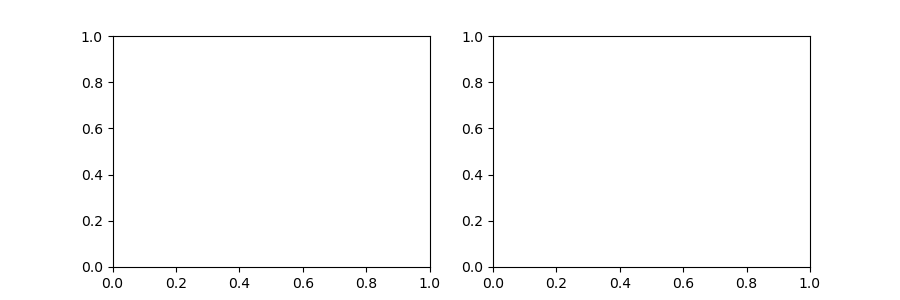

In [10]:
if "action_fig" in locals():
    plt.close(action_fig)
# action_fig = plt.figure()
# action_ax = action_fig.gca()

plt.ion()
action_fig, action_ax = plt.subplots(1, 2, figsize=[9, 3])

In [11]:
for axis in action_ax:
    axis.clear()
action_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.26, hspace=0.2)

filepath_action = f"~/user-in-the-box/output/NegativeExpDistance/{filename}/action_log.pickle"
with open(os.path.expanduser(filepath_action), "rb") as f:
    data_action = pickle.load(f)

####
EPISODE_ID = "5".zfill(len(list(data_action.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
## INFO: EPISODE_ID is taken from above
NORMALIZE_TIME = True
MINJERK_USER_CONSTRAINTS = True

N_MOVS = 3  #number of movements to visualize

ACTUATOR_ID = 0 #index of actuator to plot

####

action_series = np.squeeze(data_action[data_key]["action"])
control_series = np.squeeze(data_action[data_key]["ctrl"])
reward_series = np.squeeze(data_action[data_key]["reward"])

assert len(action_series) == len(position_series) - 1

actuator_names = ['DELT1',
 'DELT2',
 'DELT3',
 'SUPSP',
 'INFSP',
 'SUBSC',
 'TMIN',
 'TMAJ',
 'PECM1',
 'PECM2',
 'PECM3',
 'LAT1',
 'LAT2',
 'LAT3',
 'CORB',
 'TRIlong',
 'TRIlat',
 'TRImed',
 'ANC',
 'SUP',
 'BIClong',
 'BICshort',
 'BRA',
 'BRD',
 #'ECRL',
 #'ECRB',
 #'ECU',
 #'FCR',
 #'FCU',
 #'PL',
 'PT',
 'PQ',
 # 'FDSL',
 # 'FDSR',
 # 'FDSM',
 # 'FDSI',
 # 'FDPL',
 # 'FDPR',
 # 'FDPM',
 # 'FDPI',
 # 'EDCL',
 # 'EDCR',
 # 'EDCM',
 # 'EDCI',
 # 'EDM',
 # 'EIP',
 # 'EPL',
 # 'EPB',
 # 'FPL',
 #'APL'
 ]

## ANALYSIS OF POINTING TASKS -> Plot actions and rewards
solid_line = Line2D([0], [0], color='black', linestyle='-', label='Actions')
dashed_line = Line2D([0], [0], color='black', linestyle='--', label='Controls')
action_ax[0].legend(handles=[solid_line, dashed_line])


action_ax[0].set_title(f"Action and Control Time Series – {actuator_names[ACTUATOR_ID]}")
action_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
action_ax[0].set_ylabel("Action/Control [normalized]")

action_ax[1].set_title("Reward Time Series")
action_ax[1].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
action_ax[1].set_ylabel("Reward")
action_ax[1].set_yscale("symlog")

for last_idx, current_idx, next_idx in list(zip([-1] + indices, indices, indices[1:]))[:N_MOVS]:
    time_series_shifted = np.array(data_action[data_key]["timestep"][current_idx: next_idx]) - data_action[data_key]["timestep"][current_idx]
    if NORMALIZE_TIME:
        time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])

    ### ACTIONS AND CONTROLS
    action_ax[0].plot(time_series_shifted, action_series[current_idx: next_idx, ACTUATOR_ID], linestyle='-')
    action_ax[0].plot(time_series_shifted, control_series[current_idx: next_idx, ACTUATOR_ID], linestyle='--')

    ### REWARD
    latest_plot, = action_ax[1].plot(time_series_shifted, reward_series[current_idx: next_idx])

action_fig.savefig(f"plots/{filename}/actions_controls_rewards.png", dpi=120)

FileNotFoundError: [Errno 2] No such file or directory: '/home/florian/user-in-the-box/output/NegativeExpDistance/NegativeExpDistance-neural/repeated-movements/action_log.pickle'

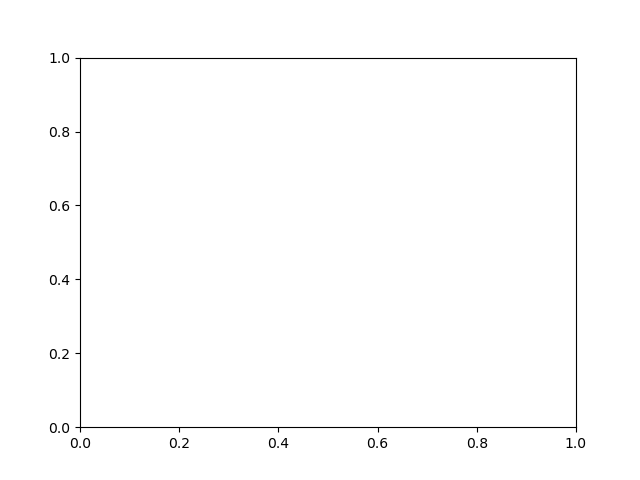

In [245]:
if "fittslaw_fig" in locals():
    plt.close(fittslaw_fig)
plt.ion()
fittslaw_fig = plt.figure()
fittslaw_ax = fittslaw_fig.gca()
# fittslaw_fig, fittslaw_ax = plt.subplots(1, 2, figsize=[9, 3])

In [311]:
fittslaw_ax.clear()

###
REMOVE_OUTLIERS = True

USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.3  #only used if USE_TARGETBOUND_AS_DIST == False

PLOT_TYPE = "alldata"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 5  #number of ID groups
DENSITY_group_IDbin_ID = 0  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
target_position_list = []
initial_position_list = []
failed_movements_counter = 0
for EPISODE_ID, data_episode in data.items():
    position_series = data_episode["fingertip_xpos"]
    time_per_step = np.diff(data_episode["timestep"]).mean()  #0.01
    if REPEATED_MOVEMENTS:
        indices = np.where(data_episode["target_spawned"])[0]
    else:
    #    indices = np.append(np.insert(np.where(data_episode["target_hit"])[0], 0, 0), len(data_episode["target_hit"]))
        indices = np.insert(np.where(data_episode["target_spawned"])[0], 0, 0)
    for last_idx, current_idx, next_idx in list(zip([-1] + list(indices), indices, indices[1:])):
        #test[idx] = (next_idx - current_idx, data_episode["target_radius"][current_idx])
        width = 2 * data_episode["target_radius"][current_idx]
        # use nominal distance:
        init_val = data_episode["target_position"][last_idx] if last_idx >= 0 else position_series[0]
        if USE_TARGETBOUND_AS_DIST:
            if "inside_target" not in data_episode:  #use "target_radius" column
                assert len(np.unique(data_episode["target_radius"][current_idx + 1:next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'USE_TARGETBOUND_AS_DIST=False')."
                rel_indices_targetbound = np.where(np.linalg.norm(np.array(position_series[current_idx + 1:next_idx]) - np.array(data_episode["target_position"][current_idx + 1:next_idx]), axis=1) < data_episode["target_radius"][current_idx + 1])[0]
            else:  #use "inside_target" column
                rel_indices_targetbound = np.where(data_episode["inside_target"][current_idx + 1:next_idx])[0]
            if len(rel_indices_targetbound) > 0 :
                targetbound_idx = current_idx + 1 + rel_indices_targetbound[0]
            else:  #movement failed
                failed_movements_counter += 1
                continue
            final_val = position_series[targetbound_idx]
        else:
            final_val = data_episode["target_position"][current_idx] #or position_series[next_idx - 1]
        if isinstance(final_val, tuple) and len(final_val) == 1:
            final_val = final_val[0]
        # # use effective distance:
        # init_val = position_series[current_idx]
        # final_val = position_series[next_idx - 1]
        ######################################
        distance = np.linalg.norm(final_val - init_val)
        fitts_ID = np.log2(2*distance/width)
        width_list.append(width)
        distance_list.append(distance)
        ID_list.append(fitts_ID)
        if USE_TARGETBOUND_AS_DIST:
            MT_list.append((targetbound_idx - current_idx)*time_per_step)
        else:
            MT_list.append((next_idx - current_idx)*time_per_step - DWELL_TIME)
        target_position_list.append(final_val)
        initial_position_list.append(init_val)
# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    #movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    movement_indices_TO_DELETE = np.where(np.array(MT_list) >= 4.0 - DWELL_TIME)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]
    target_position_list = [val for idx, val in enumerate(target_position_list) if idx not in movement_indices_TO_DELETE]
    initial_position_list = [val for idx, val in enumerate(initial_position_list) if idx not in movement_indices_TO_DELETE]

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(ID_list)} movements from {len(data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    fittslaw_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        fittslaw_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
    else:
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    fittslaw_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #fittslaw_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    fittslaw_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    fittslaw_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]   
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    fittslaw_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    fittslaw_ax.plot(df_bins["Average ID"], p_linreg(df_bins["Average ID"]), color="red")
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    fittslaw_ax.scatter(ID_list, MT_list)
    fittslaw_ax.plot(ID_list, p_linreg(ID_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average ID"] = df_bins_ID.apply(lambda x: x["ID"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    fittslaw_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "MT"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = fittslaw_ax.get_xticks()
# # Reset the xtick locations.
# fittslaw_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    fittslaw_ax.set_xlabel("MT (s)")
elif PLOT_TYPE not in ["mean_groups"]:
    fittslaw_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    fittslaw_ax.set_ylabel("Frequency")    
else:
    fittslaw_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    fittslaw_ax.set_title("Fitts' Law on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    fittslaw_ax.set_title(f"Movement Time – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    fittslaw_ax.set_title("Fitts' Law ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

if PLOT_TYPE == "density_ID":
    fittslaw_fig.savefig(f"plots/{filename}/movement_time_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
else:
    fittslaw_fig.savefig(f"plots/{filename}/fittslaw_{PLOT_TYPE}.png", dpi=120)
        

INFO: Using 250 movements from 250 episodes.
Fitts' Law - Coefficient of determination (R^2): 0.16338053545088668


In [247]:
[x/np.linalg.norm(x) for i in movement_indices_TO_DELETE if (x := (target_position_list[i] - initial_position_list[i])) is not None]

[]

In [75]:

# position_series = (np.cumsum(velocity_series, axis=0) * time_per_step)
# position_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step)).values
# position_series += target_position_series[indices[1]-1] - position_series[indices[1]-1] #ensure that target is reached at target hit/switch time

position_series[10], target_position_series[10]

(array([ 0.01647862, -0.30795222,  0.30651335]),
 (array([0.482445  , 0.11064147, 0.9822798 ]),))

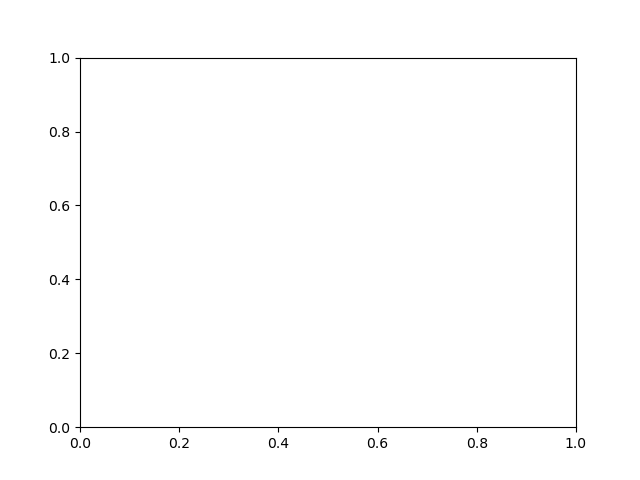

In [167]:
if "repeated_movements_fig" in locals():
    plt.close(repeated_movements_fig)
plt.ion()
repeated_movements_fig = plt.figure()
repeated_movements_ax = repeated_movements_fig.gca()
# repeated_movements_fig, repeated_movements_ax = plt.subplots(1, 2, figsize=[9, 3])

In [181]:
MOVEMENT_ID = "1".zfill(2)

rep_movs_filepath = f"~/user-in-the-box/output/{REP_MOVS_FILENAME}/repeated-movements/movement_{MOVEMENT_ID}/radius_4/state_log.pickle"

rep_movs_data = []
with open(os.path.expanduser(rep_movs_filepath), "rb") as f:
    rep_movs_data = pickle.load(f)

np.where(rep_movs_data["episode_1"]["target_hit"])

(array([ 79, 117]),)

In [ ]:
repeated_movements_ax.clear()

###
REP_MOVS_FILENAME = "NegativeExpDistance-neural"

REMOVE_OUTLIERS = True

USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.3  #only used if USE_TARGETBOUND_AS_DIST == False

PLOT_TYPE = "mean_groups"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 5  #number of ID groups
DENSITY_group_IDbin_ID = 4  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

rep_movs_filepath = f"~/user-in-the-box/output/{REP_MOVS_FILENAME}/repeated-movements"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
target_position_list = []
initial_position_list = []
failed_movements_counter = 0
for EPISODE_ID, data_episode in data.items():
    position_series = data_episode["fingertip_xpos"]
    time_per_step = np.diff(data_episode["timestep"]).mean()  #0.01
#    indices = np.append(np.insert(np.where(data_episode["target_hit"])[0], 0, 0), len(data_episode["target_hit"]))
    indices = np.insert(np.where(data_episode["target_spawned"])[0], 0, 0)
    for last_idx, current_idx, next_idx in list(zip([-1] + indices, indices, indices[1:])):
        #test[idx] = (next_idx - current_idx, data_episode["target_radius"][current_idx])
        width = 2 * data_episode["target_radius"][current_idx]
        # use nominal distance:
        init_val = data_episode["target_position"][last_idx] if last_idx >= 0 else position_series[0]
        if USE_TARGETBOUND_AS_DIST:
            if "inside_target" not in data_episode:  #use "target_radius" column
                assert len(np.unique(data_episode["target_radius"][current_idx + 1:next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'USE_TARGETBOUND_AS_DIST=False')."
                rel_indices_targetbound = np.where(np.linalg.norm(np.array(position_series[current_idx + 1:next_idx]) - np.array(data_episode["target_position"][current_idx + 1:next_idx]), axis=1) < data_episode["target_radius"][current_idx + 1])[0]
            else:  #use "inside_target" column
                rel_indices_targetbound = np.where(data_episode["inside_target"][current_idx + 1:next_idx])[0]
            if len(rel_indices_targetbound) > 0 :
                targetbound_idx = current_idx + 1 + rel_indices_targetbound[0]
            else:  #movement failed
                failed_movements_counter += 1
                continue
            final_val = position_series[targetbound_idx]
        else:
            final_val = data_episode["target_position"][current_idx] #or position_series[next_idx - 1]
        if isinstance(final_val, tuple) and len(final_val) == 1:
            final_val = final_val[0]
        # # use effective distance:
        # init_val = position_series[current_idx]
        # final_val = position_series[next_idx - 1]
        ######################################
        distance = np.linalg.norm(final_val - init_val)
        fitts_ID = np.log2(2*distance/width)
        width_list.append(width)
        distance_list.append(distance)
        ID_list.append(fitts_ID)
        if USE_TARGETBOUND_AS_DIST:
            MT_list.append((targetbound_idx - current_idx)*time_per_step)
        else:
            MT_list.append((next_idx - current_idx)*time_per_step - DWELL_TIME)
        target_position_list.append(final_val)
        initial_position_list.append(init_val)
# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    #movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    movement_indices_TO_DELETE = np.where(np.array(MT_list) >= 4.0 - DWELL_TIME)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]
    target_position_list = [val for idx, val in enumerate(target_position_list) if idx not in movement_indices_TO_DELETE]
    initial_position_list = [val for idx, val in enumerate(initial_position_list) if idx not in movement_indices_TO_DELETE]

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(ID_list)} movements from {len(data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    repeated_movements_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    repeated_movements_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        repeated_movements_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
    else:
        df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if BOXPLOT_qbins:
        df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    else:
        df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    repeated_movements_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    repeated_movements_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #repeated_movements_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #repeated_movements_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    repeated_movements_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    repeated_movements_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    repeated_movements_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
    else:
        df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    repeated_movements_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    repeated_movements_ax.plot(df_bins["Average ID"], p_linreg(df_bins["Average ID"]), color="red")
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    repeated_movements_ax.scatter(ID_list, MT_list)
    repeated_movements_ax.plot(ID_list, p_linreg(ID_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average ID"] = df_bins_ID.apply(lambda x: x["ID"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    repeated_movements_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "MT"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = repeated_movements_ax.get_xticks()
# # Reset the xtick locations.
# repeated_movements_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_xlabel("MT (s)")
elif PLOT_TYPE not in ["mean_groups"]:
    repeated_movements_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_ylabel("Frequency")    
else:
    repeated_movements_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    repeated_movements_ax.set_title("Fitts' Law on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_title(f"Movement Time – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    repeated_movements_ax.set_title("Fitts' Law ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

if PLOT_TYPE == "density_ID":
    repeated_movements_fig.savefig(f"plots/{REP_MOVS_FILENAME}/repeated_movs_movement_time_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
else:
    repeated_movements_fig.savefig(f"plots/{REP_MOVS_FILENAME}/repeated_movs_fittslaw_{PLOT_TYPE}.png", dpi=120)
        

/tmp/ipykernel_2270/1845835282.py:65: RuntimeWarning: divide by zero encountered in log2
  fitts_ID = np.log2(2*distance/width)
/home/florian/.conda/envs/SG_florian/lib/python3.8/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


INFO: Using 500 movements from 250 episodes.
